In [126]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data normalization and standardization 
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

#Training and testing split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier

#Evalution
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


## Loading Training/Testing Data:

In [127]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

training_set = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
testing_set = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')

train_df = pd.DataFrame(training_set)
test_df = pd.DataFrame(testing_set)

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [128]:
# conda install ecos
# conda install CVXcanon
# !pip install fancyimpute

In [129]:
# # replace null values in df w/ values that had most counts for each column
# train_df = train_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
#                           else x.fillna(train_df.columns.value_counts().idxmax()))
# test_df = test_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' \
#                           else x.fillna(train_df.columns.value_counts().idxmax()))
# # combining the training and test dfs
# # dfs = [train_df, test_df]
# # df = pd.concat(dfs)

# test_df.head()

In [130]:
train_df['CentralAir'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0})
train_df['PavedDrive'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0.5,
 'P': 0})
train_df.head()

test_df['CentralAir'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0})
test_df['PavedDrive'] = train_df.MSZoning.map(
{'Y': 1,
 'N': 0.5,
 'P': 0})
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Data Preprocessing:

In [131]:
train_df = pd.get_dummies(data=train_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                                                   'MasVnrType', 'ExterQual','ExterCond', 'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
                                                   'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 
                                                   'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                                                   'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                                                  'MiscFeature', 'SaleType', 'SaleCondition'])
train_df.head()

test_df = pd.get_dummies(data=test_df , columns=['MSZoning','Street', 'Alley', 'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                                                   'MasVnrType', 'ExterQual','ExterCond', 'Foundation', 'BsmtQual',
                                                   'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
                                                   'Heating', 'HeatingQC', 'Electrical', 'KitchenQual', 
                                                   'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
                                                   'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
                                                  'MiscFeature', 'SaleType', 'SaleCondition'])
test_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [132]:
train_filled_knn = KNN(k=1).fit_transform(train_df)   
train_df = pd.DataFrame(train_filled_knn, columns = list(train_df.columns))
train_df.head()

test_filled_knn = KNN(k=1).fit_transform(test_df)   
test_df = pd.DataFrame(test_filled_knn, columns = list(test_df.columns))
test_df.head()

Imputing row 1/1460 with 2 missing, elapsed time: 3.491
Imputing row 101/1460 with 3 missing, elapsed time: 3.495
Imputing row 201/1460 with 2 missing, elapsed time: 3.498
Imputing row 301/1460 with 2 missing, elapsed time: 3.501
Imputing row 401/1460 with 2 missing, elapsed time: 3.505
Imputing row 501/1460 with 2 missing, elapsed time: 3.508
Imputing row 601/1460 with 2 missing, elapsed time: 3.511
Imputing row 701/1460 with 2 missing, elapsed time: 3.515
Imputing row 801/1460 with 2 missing, elapsed time: 3.518
Imputing row 901/1460 with 3 missing, elapsed time: 3.522
Imputing row 1001/1460 with 2 missing, elapsed time: 3.525
Imputing row 1101/1460 with 2 missing, elapsed time: 3.528
Imputing row 1201/1460 with 2 missing, elapsed time: 3.532
Imputing row 1301/1460 with 3 missing, elapsed time: 3.535
Imputing row 1401/1460 with 2 missing, elapsed time: 3.538
[KNN] Warning: 2920/417560 still missing after imputation, replacing with 0
Imputing row 1/1459 with 2 missing, elapsed time: 3

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [133]:
test_df.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 267, dtype: int64

In [138]:
#Independent Variable
X = train_df.loc[:,~train_df.columns.isin(['SalePrice'])]

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)



# X_scaled = preprocessing.scale(X)
# #Dependent Variable
# y_train = train_df.loc[:,'SalePrice']

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

array([[6.000e+01, 6.500e+01, 8.450e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.000e+01, 8.000e+01, 9.600e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.000e+01, 6.800e+01, 1.125e+04, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [7.000e+01, 6.600e+01, 9.042e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.000e+01, 6.800e+01, 9.717e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.000e+01, 7.500e+01, 9.937e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

## Data normalization and standardization

In [135]:
#Data normalization and standardization
rescaledX_train = preprocessing.scale(X_train)
rescaledX_test = preprocessing.scale(X_test)

### Logestic Regression ###

In [137]:


logReg = LogisticRegression(random_state = 42,solver='lbfgs', max_iter=300000)
logReg.fit(rescaledX_train,y_train)

LogisticRegression(max_iter=300000, random_state=42)

In [91]:
#Model1 Evalution

y_pred = logReg.predict(rescaledX_test)
print('Accuracy of logistic regression classifier:', accuracy_score(y_test,y_pred))
# print('Roc Auc Score:',roc_auc_score(y_test,y_pred))
print('Confusion Matrix of the logreg model: ',confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier: 0.00684931506849315
Confusion Matrix of the logreg model:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# # encode object (categorical) columns in df
# enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)

# # add encoded columns back into original train df
# train_df[enc_df.columns] = enc_df
# train_df.head()

In [ ]:
# #print(train_df.MSZoning)

# #df = train_df.groupby('MSZoning').size()
# #print (df)

# # Converting category labels to numerical values for MSZoning column
# train_df['MSZoning_Num'] = train_df.MSZoning.map(
# {'C (all)': 1,
#  'FV': 2,
#  'RH': 3,
#  'RL': 4,
#  'RM': 5})

# #print(train_df.MSZoning_Num)

In [ ]:
# #print(train_df.LotConfig)

# #df = train_df.groupby('LotConfig').size()
# #print (df)

# # Converting category labels to numerical values for LotConfig column
# train_df['LotConfig_Num'] = train_df.LotConfig.map(
# {'Corner': 1,
#  'CulDSac': 2,
#  'FR2': 3,
#  'FR3': 4,
#  'Inside': 5})

# #print(train_df.LotConfig_Num)    

In [ ]:
# #print(train_df.Neighborhood)

# #df = train_df.groupby('Neighborhood').size()
# #print (df)

# # Converting category labels to numerical values for Neighborhood column
# train_df['Neighborhood_Num'] = train_df.Neighborhood.map(
# {'Blmngtn': 1,
#  'Blueste': 2,
#  'BrDale': 3,
#  'BrkSide': 4,
#  'ClearCr': 5,
#  'CollgCr': 6,
#  'Crawfor': 7,
#  'Edwards': 8,
#  'Gilbert': 9,
#  'IDOTRR':  10,
#  'MeadowV': 11,
#  'Mitchel': 12,
#  'NAmes': 13,
#  'NPkVill': 14,
#  'NWAmes': 15,
#  'NoRidge': 16,
#  'NridgHt': 17,
#  'OldTown': 18,
#  'SWISU': 19,
#  'Sawyer': 20,
#  'SawyerW': 21,
#  'Somerst': 22,
#  'StoneBr': 23,
#  'Timber': 24,
#  'Veenker': 25})

# #print(train_df.Neighborhood_Num)

In [ ]:
# #print(train_df.KitchenQual)

# #df = train_df.groupby('KitchenQual').size()
# #print (df)

# # Converting category labels to numerical values for KitchenQual column
# train_df['KitchenQual_Num'] = train_df.KitchenQual.map(
# {'Po':1, 
#  'Fa':2, 
#  'TA':3, 
#  'Gd':4, 
#  'Ex':5})

# #print(train_df.KitchenQual_Num)

In [ ]:
# #print(train_df.SaleCondition)

# #df = train_df.groupby('SaleCondition').size()
# #print (df)

# # Converting category labels to numerical values for SaleCondition column
# train_df['SaleCondition_Num'] = train_df.SaleCondition.map(
# {'Abnorml':1, 
#  'AdjLand':2, 
#  'Alloca':3, 
#  'Family':4, 
#  'Normal':5,
#  'Partial':6})

# #print(train_df.SaleCondition_Num)

## Data Exploration:

In [6]:
# looking at correlation of numeric features to SalePrice column. 
# this will suggest which columns have a greater relationship with the SalePrice column 
corr = train_df.corr().abs().unstack().sort_values(ascending=False)['SalePrice']
corr = corr.iloc[1:]
corr.head(40)

OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
ExterQual_TA             0.589044
FullBath                 0.560664
BsmtQual_Ex              0.553105
TotRmsAbvGrd             0.533723
YearBuilt                0.522897
KitchenQual_TA           0.519298
YearRemodAdd             0.507101
KitchenQual_Ex           0.504094
Foundation_PConc         0.497734
GarageYrBlt              0.486362
MasVnrArea               0.477493
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtQual_TA              0.452394
ExterQual_Ex             0.451164
BsmtFinType1_GLQ         0.434597
HeatingQC_Ex             0.434543
GarageFinish_Fin         0.419678
GarageFinish_Unf         0.410608
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
MasVnrType_None          0.374468
SaleType_New             0.357509
GarageType_Det

Text(0.5, 1.0, 'Price vs Overall Quality')

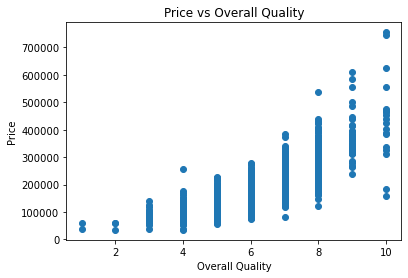

In [7]:
# show how sales price varies with overall quality
plt.scatter(train_df.OverallQual, train_df.SalePrice)
plt.xlabel("Overall Quality")
plt.ylabel('Price')
plt.title("Price vs Overall Quality")

Text(0.5, 1.0, 'Price vs Garage Size')

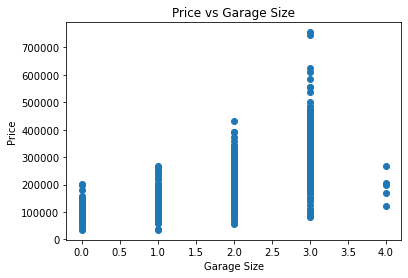

In [8]:
# show how sales price varies with garage size in car capacity
plt.scatter(train_df.GarageCars, train_df.SalePrice)
plt.xlabel("Garage Size")
plt.ylabel('Price')
plt.title("Price vs Garage Size")

Text(0.5, 1.0, 'Price vs GrLivArea')

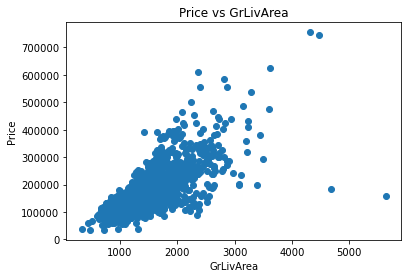

In [83]:

plt.scatter(train_df.GrLivArea, train_df.SalePrice)
plt.xlabel("GrLivArea")
plt.ylabel('Price')
plt.title("Price vs GrLivArea")

## Data Visualization (CAN BE DELETED):

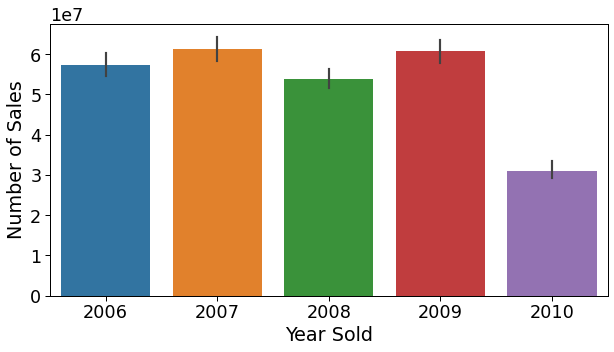

In [84]:
#Count the number of houses sold in a year
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc='count')
#print(year_sold_pivot)

# Plotting the sum of sales per year
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=sum)
plt.xlabel('Year Sold')
plt.ylabel('Number of Sales')
plt.show()

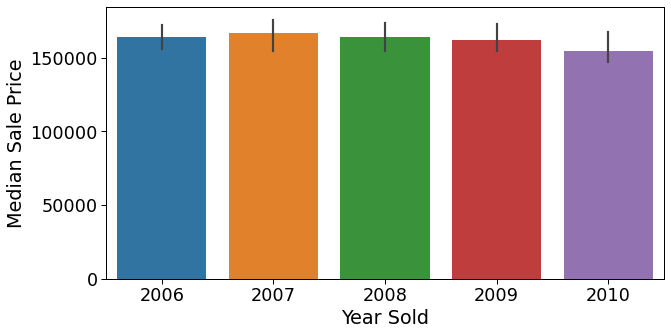

In [85]:
# Plotting the median sale price for each year

#Checking the median price
#year_sold_pivot = train_df.pivot_table(index='YrSold', values='SalePrice', aggfunc=np.median)
#print(year_sold_pivot)

sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.barplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']], estimator=np.median)
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

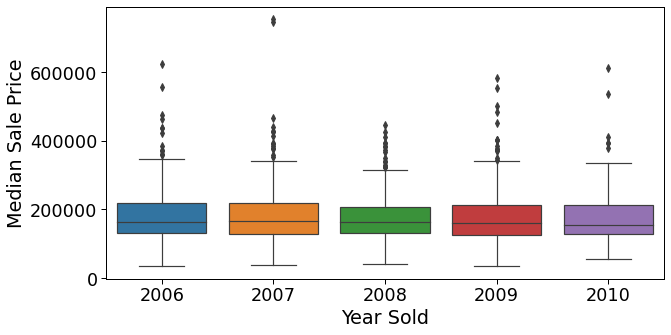

In [86]:
#Displaying the median price for each year using box plot.  
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(10,5))
sns.boxplot(x='YrSold', y='SalePrice', data=train_df[['SalePrice', 'YrSold']])
plt.xlabel('Year Sold')
plt.ylabel('Median Sale Price')
plt.show()

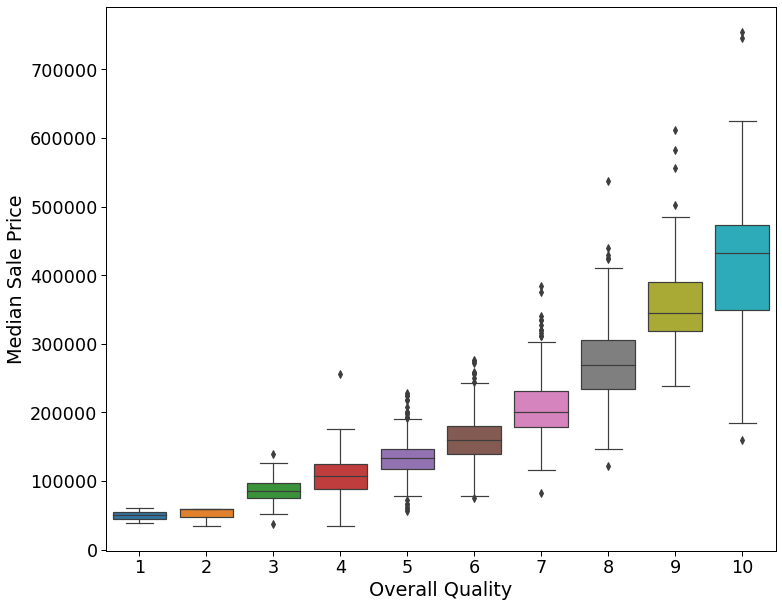

In [87]:
#Displaying the median price based on overall quality of the house using box plot.
sns.set_context("paper", font_scale=2) 
plt.figure(figsize=(12,10))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df[['SalePrice', 'OverallQual']])
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.show()

In [9]:
# # Plotting the median sale price based on kitchen quality
# sns.set_context("paper", font_scale=2) 
# plt.figure(figsize=(10,5))
# sns.barplot(x='KitchenQual', y='SalePrice', data=train_df[['SalePrice', 'KitchenQual']], estimator=np.median)
# plt.xlabel('Kitchen Quality')
# plt.ylabel('Median Sale Price')
# plt.show()

## Feature Engineering:

In [ ]:
# Ratio of Basement Quality ['BsmtQual'] to Overall Quality ['OverallQual']

In [ ]:
# Ratio of Exterior Quality ['ExterQual'] to Overall Quality ['OverallQual']

In [ ]:
# Ratio of Kitchen Quality ['KitchenQual'] to Overall Quality ['OverallQual']

In [ ]:
################## DISREGARD LOGIC BELOW ######################

In [ ]:
# encode object columns
# enc_df = train_df.select_dtypes(include=['object']).apply(LabelEncoder().fit_transform)
# enc_df

In [ ]:
# add encoded columns back into train df
# train_df[enc_df.columns] = enc_df
# train_df

In [ ]:
# normalize df except for price column
# norm_df = (train_df - train_df.mean()) / (train_df.max() - train_df.min())